(ch:computer-vision-advanced)=
# 고급 컴퓨터 비전

**감사의 글**

아래 내용은 프랑소와 숄레의 
[Deep Learning with Python(2판)](https://github.com/fchollet/deep-learning-with-python-notebooks)의 
소스코드 내용을 참고해서 작성되었습니다.
자료를 공개한 저자에게 진심어린 감사를 전합니다.

**소스코드**

여기서 언급되는 코드를
[(구글 코랩) 컴퓨터 비전 기초: 합성곱 신경망](https://colab.research.google.com/github/codingalzi/dlp2/blob/master/notebooks/NB-computer_vision_intro.ipynb)에서 
직접 실행할 수 있다.

**주요 내용**

- 합성곱 신경망의 주요 활용 분야(컴퓨터 비전)
    - 이미지 분류
    - 이미지 분할
    - 객체 탐지
- 합성곱 신경망 기본 아키텍처
    - 잔차 연결(residual connections)
    - 배치 정규화(batch normalization)
    - 채널 분리 합성곱(depthwise separable convolutions)
- 합성곱 신경망 학습 내용 시각화

## 컴퓨터 비전 분야 세 가지 주요 과제

컴퓨터 비전 분야에서 가장 주요한 연구 주제는 다음 세 가지이다.

- 이미지 분류(image classification): 이미지에 포함된 사물(들)의 클래스 분류
    - 단일 레이블 분류(single-label classification)
        - 예제: 한 장의 사진에서 고양이, 강아지, 사람, 자전거, 자동차 등 중에하 하나의 클래스 선택 
    - 다중 레이블 분류(multi-label classification)
        - 예제: 한 장의 사진에 포함된 여러 종류의 객체를 모두 분류.
        예를 들어 두 사람이 자전거를 타는 사진에서 두 사람과 자전거 등 사진에 포함된 모든 객체의 클래서 확인.
- 이미지 분할(image segmentation): 이미지를 특정 클래스를 포함하는 영역으로 분할
    - 예제: 줌(Zoom), 구글 미트(Google Meet) 등에서 사용되는 배경 블러처리 기능
- 객체 탐지(object detection): 이미지에 포함된 객체 주의에 경계상자(bounding box) 그리기
    - 예제: 자율주행 자동차의 주변에 위치한 다른 자동차, 행인, 신호등 등 탐지 기능

<div align="center"><img src="https://drek4537l1klr.cloudfront.net/chollet2/v-7/Figures/computer_vision_tasks.png" style="width:100%;"></div>

<p><div style="text-align: center">&lt;그림 출처: <a href="https://www.manning.com/books/deep-learning-with-python-second-edition">Deep Learning with Python(2판)</a>&gt;</div></p>

언급된 3 분야 이외에 아래 컴퓨터 비전 분야에서도 딥러닝이 중요하게 활용된다.

- 이미지 유사도 측정(image similarity scoring),
- 키포인트 탐지(keypoint detection),
- 자세 추정(pose estimation),
- 3D 메쉬 추정(3D mesh estimation), 등등

<div align="center"><img src="https://github.com/Jeff-sjtu/HybrIK/raw/main/assets/hybrik.png" style="width:100%;"></div>

<div align="center"><img src="https://github.com/Jeff-sjtu/HybrIK/raw/main/assets/decompose.gif" style="width:80%;"></div>

<p><div style="text-align: center">&lt;그림 출처: <a href="https://github.com/Jeff-sjtu/HybrIK">HybrIK</a>&gt;</div></p>

하지만 객체 탐지를 포함해서 언급된 분야 모두
기초 수준을 넘어서기에 여기서는 다루지 않는다.
다만 객체 탐지 관련해서 다음 논문을 참고할 것을 권유한다.

- 객체 탐지 참고 자료: [RetinaNet 활용 객체 탐지](https://keras.io/examples/vision/retinanet/)

아래에서는 이미지 분할을 예제를 활용하여 좀 더 상세하게 설명한다.

## 이미지 분할

이미지 분할은 크게 두 종류 방식을 사용한다.

- 시맨틱 분할(semantic segmentation): 클래스 별 분할.
    - 아래 사진 왼편: 배경과 구분된 고양이들을 묶어서 cat 클래스로 구별하지 않고 분류.
- 인스턴스 분할(instance segmentation): 클래스 및 객체 별 분할.
    - 아래 사진 오른편: 배경과 구분된 각각의 고양이를 cat1, cat2 등으로 구별해서 분류.

<div align="center"><img src="https://drek4537l1klr.cloudfront.net/chollet2/v-7/Figures/instance_segmentation.png" style="width:100%;"></div>

<p><div style="text-align: center">&lt;그림 출처: <a href="https://www.manning.com/books/deep-learning-with-python-second-edition">Deep Learning with Python(2판)</a>&gt;</div></p>

**예제: 시맨틱 분할 모델 훈련**

고양이와 강아지 사진을 이용하여 시맨틱 분할을 상세히 살펴보기 위해 
[Oxford-IIIT 애완동물 데이터셋](https://www.robots.ox.ac.uk/~vgg/data/pets/)을 이용한다.

데이터셋은 강아지와 고양이를 비롯해서 37종의 애완동물의 다양한 크기와 다양한 자세를 담은
7,390장의 사진으로 구성된다.

- 데이터셋 크기: 7,390
- 총 클래스 수: 37
- 클래스 별 사진 수: 약 200 장
- 사진 별 레이블: 종과 품종, 머리 표시 경계상자, 트라이맵 분할(trimap segmentation) 마스크

**트라이맵 분할 마스크**는 원본 사진과 동일한 크기의 흑백 사진이며
각각의 픽셀은 1, 2, 3 셋 중에 하나의 값을 갖는다.

- 1: 사물
- 2: 배경
- 3: 윤곽

<div align="center"><img src="https://www.robots.ox.ac.uk/~vgg/data/pets/pet_annotations.jpg" style="width:100%;"></div>

<p><div style="text-align: center">&lt;그림 출처: <a href="https://www.manning.com/books/deep-learning-with-python-second-edition">Deep Learning with Python(2판)</a>&gt;</div></p>

**이미지 분할 모델 구성**

이미지 분할 모델의 구성은 기본적으로 `Conv2D` 층으로 구성된 
**다운샘플링** 블록(downsampling block)과
`Conv2DTranspose` 층으로 구성된 
**업샘플링** 블록(upsampling block)으로 이루어진다.

- 다운샘플링 블록: `Conv2D` 층 활용
    - 이미지 분류 모델과 동일한 기능.
    - 보폭(`strides=2`)을 사용하는 경우와 그렇지 않은 경우를 연속으로 적용.
        따라서 `MaxPooling2D`은 사용하지 않음.
    - 패딩(`padding="same"`)을 사용하지만 보폭을 2로 두기 때문에
        이미지 크기는 가로, 세로 모두 1/2로 줄어듦.
    - 채널 수는 동일한 방식으로 2배로 증가시킴.
- 업샘플링 블록: `Conv2DTranspose` 층 활용
    - 이미지 분할 모델의 최종 출력값은 원본 이미지의 트라이맵 분할 이미지임.
        따라서 동일한 크기의 넘파이 어레이를 출력해야 함.
    - `Conv2D` 층을 통과하면서 작아진 텐설를 원본 이미지 크기로 되돌리는 기능 수행.
    - 따라서 `Conv2D` 층이 적용된 역순으로 크기를 되돌려야 함.
    - 모델 훈련과정에서 어떤 값들을 사용하여 모양을 되돌지지 학습함.

```python
def get_model(img_size, num_classes):
    inputs = keras.Input(shape=img_size + (3,))
    x = layers.Rescaling(1./255)(inputs)

    x = layers.Conv2D(64, 3, strides=2, activation="relu", padding="same")(x)
    x = layers.Conv2D(64, 3, activation="relu", padding="same")(x)
    x = layers.Conv2D(128, 3, strides=2, activation="relu", padding="same")(x)
    x = layers.Conv2D(128, 3, activation="relu", padding="same")(x)
    x = layers.Conv2D(256, 3, strides=2, padding="same", activation="relu")(x)
    x = layers.Conv2D(256, 3, activation="relu", padding="same")(x)

    x = layers.Conv2DTranspose(256, 3, activation="relu", padding="same")(x)
    x = layers.Conv2DTranspose(256, 3, activation="relu", padding="same", strides=2)(x)
    x = layers.Conv2DTranspose(128, 3, activation="relu", padding="same")(x)
    x = layers.Conv2DTranspose(128, 3, activation="relu", padding="same", strides=2)(x)
    x = layers.Conv2DTranspose(64, 3, activation="relu", padding="same")(x)
    x = layers.Conv2DTranspose(64, 3, activation="relu", padding="same", strides=2)(x)

    outputs = layers.Conv2D(num_classes, 3, activation="softmax", padding="same")(x)

    model = keras.Model(inputs, outputs)
    return model
```

:::{admonition} `Conv2D` 층의 보폭 사용
:class: info

이미지 분류의 경우와는 달리 맥스풀링을 사용하는 대신 `Conv2D` 층에서 보폭을 2로 
설정하는 이유는 픽셀에 담긴 값(정보) 뿐만 아니라 각 픽셀의 위치도 중요하기 때문이다.
맥스풀링은 이와는 달리 위치와 독립적인 패턴을 알아내는 것이 중요할 때 사용한다.
:::

생성된 모델을 요약하면 다음과 같다.

```python
>>> img_size = (200, 200)
>>> model = get_model(img_size=img_size, num_classes=3)
>>> model.summary()
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
=================================================================
input_1 (InputLayer)         [(None, 200, 200, 3)]     0         
_________________________________________________________________
rescaling (Rescaling)        (None, 200, 200, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 100, 100, 64)      1792      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 100, 100, 64)      36928     
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 50, 50, 128)       73856     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 50, 50, 128)       147584    
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 25, 25, 256)       295168    
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 25, 25, 256)       590080    
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 25, 25, 256)       590080    
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 50, 50, 256)       590080    
_________________________________________________________________
conv2d_transpose_2 (Conv2DTr (None, 50, 50, 128)       295040    
_________________________________________________________________
conv2d_transpose_3 (Conv2DTr (None, 100, 100, 128)     147584    
_________________________________________________________________
conv2d_transpose_4 (Conv2DTr (None, 100, 100, 64)      73792     
_________________________________________________________________
conv2d_transpose_5 (Conv2DTr (None, 200, 200, 64)      36928     
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 200, 200, 3)       1731      
=================================================================
Total params: 2,880,643
Trainable params: 2,880,643
Non-trainable params: 0
_________________________________________________________________
```

훈련중 저장된 최고 성능의 모델을 불러와서 이미지 분할을
어떻게 진행했는지 하나의 이미지에 대해 테스트해보면
원본 이미지에 포함된 다른 요소들 때문에 약간의 잡음이 있지만
대략적으로 이미지 분할을 잘 적용함을 알 수 있다.

<div align="center"><img src="https://drek4537l1klr.cloudfront.net/chollet2/Figures/09-06.png" style="width:700px;"></div>

<p><div style="text-align: center">&lt;그림 출처: <a href="https://www.manning.com/books/deep-learning-with-python-second-edition">Deep Learning with Python(2판)</a>&gt;</div></p>

## 합성곱 신경망 모델의 주요 아키텍처 유형

**모델 아키텍처**는 모델 설계방식을 의미하며
딥러닝 모델을 구성할 때 매우 중요하다.
주어진 데이터셋과 해결해야 문제에 따라 적절한 층을 적절하게 구성해서
모델을 구현해야 한다.
좋은 모델 아키텍처를 사용할 수록 적은 양의 데이터을 이용하여 보다 빠르게
좋은 성능의 모델을 얻을 가능성이 높아진다. 
아쉽게도 좋은 모델 아키텍처와 관련된 이론은 없으며
많은 경험을 통한 직관이 보다 중요한 역할을 수행한다. 

여기서는 실전에서 최고 성능을 발휘한 합성곱 신경망 몇 개를 이용하여
주요 합성곱 신경망 모델의 기본이 되는 아키텍처 3 개를 살펴본다.

- 잔차 연결(residual connections)
- 배치 정규화(batch normalization)
- 채널 분리 합성곱(depthwise separable convolutions)

### 블록, 계층, 재활용

모든 유명한 합성곱 신경망 모델은 **블록(모듈)**을 **계층**적으로 쌓아 올린 구조를 갖는다.
여기서 블록(모듈)은 여러 개의 층(레이어)으로 구성되며, 하나의 블록(모듈)이 여러 번 **재활용**되기도 한다. 
예를 들어, 8장에서 다룬 VGG16 모델은 "Conv2D, Conv2D, MaxPooling2D" 로 구성된 블록(모듈)을 
계층적으로 구성하였다. 

대부분의 합성곱 신경망 모델의 또다른 특징는 **특성 피라미드** 형식의 계층적 구조를 사용하는 점이다.
VGG16의 경우에 필터 수를 32, 64, 128 등으로 수를 늘리는 반면에 특성맵(feature maps)의 
크기는 그에 상응하게 줄여 나간다(아래 그림 참조).

<div align="center"><img src="https://drek4537l1klr.cloudfront.net/chollet2/Figures/09-08.png" style="width:80%;"></div>

그림 출처: [Deep Learning with Python(Manning MEAP)](https://www.manning.com/books/deep-learning-with-python-second-edition)

**좁은 층 깊은 신경망 모델**

일반적으로 많은 유닛이 포함된 층을 몇 게 쌓는 것보다
적은 유닛이 포함된 층을 높이 쌓을 때 모델의 성능이 좋아진다. 
하지만 층을 높이 쌓을 수록
전달되어야 하는 손실값(오차)의 **그레이디언트 소실 문제**(vanishing gradient problem)가 
발생하여 이를 극복해야 하는 아키텍처(설계방식)을 사용해야 한다.
이를 위한 대표적인 아키텍처는 **잔차 연결**(residual connections)이다.

**참고**: 층을 통과할 때 어쩔 수 없이 발생하는 노이즈(잡음) 때문에 그레이디언트 소실 문제가 발생한다.

### 잔차 연결

블록(모듈)의 입력값을 블록을 통과하여 생성된 출력값과 합쳐서 다음 블록으로 전달하는 아키텍처이다(아래 그림 참조).
이 방식을 통해 블록의 입력값에 대한 정보가 보다 정확하게 상위 블록에 전달되어,
그레이디언트 소실 문제를 해결하는 데에 많은 도움을 준다.
실제로 잔차 연결을 이용하면 블록을 매우 높게 쌓아도 모델 훈련이 가능하다.

**참고**: 잔차 연결 아키텍처는 2015년에 소개된 ResNet 계열의 모델에서 처음 사용되었으며,
2015년 ILSVRC 이미지 분류 경진대회에서 1등을 차지했다.

<div align="center"><img src="https://drek4537l1klr.cloudfront.net/chollet2/Figures/09-09.png" style="width:30%;"></div>

그림 출처: [Deep Learning with Python(Manning MEAP)](https://www.manning.com/books/deep-learning-with-python-second-edition)

**잔차 연결 핵심: 모양(shape) 맞추기**

잔차 연결을 사용할 때 주의해야할 기본사항은 블록의 입력텐서와 출력테서의 모양을 맞추는 일이다.
이때 맥스풀링 사용여부에 따라 보폭(`strides`)의 크기가 달라진다.

먼저, 맥스풀링을 사용하지 않는 경우엔 `Conv2D`에서 사용된 필터 수를 맞추는 데에만 주의하면 된다.

- `Conv2D` 층: `padding="same"` 옵션을 사용하여 모양을 유지
- 필터 수가 변하는 경우: 잔차에 `Conv2D` 층을 이용하여 필터 수를 맞춤. 필터 크기는 `1x1` 사용.
    활성화 함수는 없음.

In [ ]:
from tensorflow import keras
from tensorflow.keras import layers

inputs = keras.Input(shape=(32, 32, 3))
x = layers.Conv2D(32, 3, activation="relu")(inputs)

residual = x

x = layers.Conv2D(64, 3, activation="relu", padding="same")(x)  # padding 사용

residual = layers.Conv2D(64, 1)(residual)                       # 필터 수 맞추기

x = layers.add([x, residual])

맥스풀링을 사용하는 경우엔 보폭을 활용해야 한다.

- 잔차에 `Conv2D` 층을 적용할 때 보폭 사용

In [ ]:
inputs = keras.Input(shape=(32, 32, 3))
x = layers.Conv2D(32, 3, activation="relu")(inputs)

residual = x

x = layers.Conv2D(64, 3, activation="relu", padding="same")(x)
x = layers.MaxPooling2D(2, padding="same")(x)                   # 맥스풀링

residual = layers.Conv2D(64, 1, strides=2)(residual)            # 보폭 사용

x = layers.add([x, residual])

**예제**

아래 코드는 잔차 연결을 사용하는 활용법을 보여준다.
맥스풀링과 필터 수에 따른 구분을 사용함에 주의하라.

In [ ]:
# 입력층
inputs = keras.Input(shape=(32, 32, 3))
x = layers.Rescaling(1./255)(inputs)

# 은닉층
def residual_block(x, filters, pooling=False):
    residual = x
    x = layers.Conv2D(filters, 3, activation="relu", padding="same")(x)
    x = layers.Conv2D(filters, 3, activation="relu", padding="same")(x)
    if pooling:                          # 맥스풀링 사용하는 경우
        x = layers.MaxPooling2D(2, padding="same")(x)
        residual = layers.Conv2D(filters, 1, strides=2)(residual)
    elif filters != residual.shape[-1]:  # 필터 수가 변하는 경우
        residual = layers.Conv2D(filters, 1)(residual)
    x = layers.add([x, residual])
    
    return x

x = residual_block(x, filters=32, pooling=True)
x = residual_block(x, filters=64, pooling=True)
x = residual_block(x, filters=128, pooling=False)

x = layers.GlobalAveragePooling2D()(x) # 채널 별로 하나의 값(채널 평균값) 선택

# 출력층
outputs = layers.Dense(1, activation="sigmoid")(x)

# 모델 설정
model = keras.Model(inputs=inputs, outputs=outputs)

모델 구성 요약은 다음과 같다.

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
rescaling (Rescaling)           (None, 32, 32, 3)    0           input_3[0][0]                    
__________________________________________________________________________________________________
conv2d_6 (Conv2D)               (None, 32, 32, 32)   896         rescaling[0][0]                  
__________________________________________________________________________________________________
conv2d_7 (Conv2D)               (None, 32, 32, 32)   9248        conv2d_6[0][0]                   
______________________________________________________________________________________________

### 배치 정규화

**정규화**(normalization)는 다양한 모양의 샘플을 정규화를 통해 보다 유사하게 만들어
모델의 학습을 도와주고 훈련된 모델의 일반화 성능을 올려준다.
지금까지 살펴 본 정규화는 모델의 입력 데이터를 전처리 과정에서 평균을 0으로, 
표준편차를 1로 만드는 방식이었다. 
이는 데이터셋이 정규분포를 따른다는 가정 하에 진행된 정규화였다.
아래 그림은 주택가격 예측 데이터의 특성 중에 주택가격과 건축년수를 정규화한 경우(오른편)와 그렇지 않는 경우(왼편)의
데이터 분포의 변화를 보여준다.

**참고**: 정규분포를 따르지 않는 데이터에 대한 분석은 기본적으로 머신러닝(딥러닝) 기법을 적용할 수 없다.

<div align="center"><img src="https://miro.medium.com/max/770/1*4T4y3kI0R9Alk_2pe6B4Pg.png" style="width:70%;"></div>

그림 출처: [Batch Normalization — Speed up Neural Network Training](https://medium.com/@ilango100/batch-normalization-speed-up-neural-network-training-245e39a62f85)

하지만 입력 데이터셋에 대한 정규화는 출력값의 정규화를 전혀 보장하지 않는다.
따라서 다음 층으로 넘겨주기 전에 정규화를 먼저 진행하면 보다 훈련이 잘 될 수 있다.
더 나아가 출력값을 먼저 정규화한 후에 활성화 함수를 적용할 때 보다 좋은 성능의 모델이 구현될 수 있음이
발혀지기도 했다. 

<div align="center"><img src="https://raw.githubusercontent.com/codingalzi/dlp/master/notebooks/images/batchNormalization.jpg" style="width:70%;"></div>

그림 출처: [Batch Normalization — Speed up Neural Network Training](https://medium.com/@ilango100/batch-normalization-speed-up-neural-network-training-245e39a62f85)

**배치 정규화**(batch normalization)가 바로 앞서 설명한 기능을 대신 처리하며,
2015년에 발표된 한 논문에서 소개되었다. 
케라스의 경우 `layers.BatchNormalization` 층이 배치 정규하를 지원한다.

배치 정규화로 인한 모델 성능 향상에 대한 구체적인 이론은 아직 존재하지 않는다.
다만 경험적으로 많은 합성곱 신경망 모델의 성능에 도움을 준다는 사실만 알려져 있을 뿐이다.
잔차 연결과 함께 배치 정규화 또한 모델 훈련과정에 그레이디언트 역전파에 도움을 주어
매우 깊은 딥러닝 모델의 훈련에 도움을 준다.
예를 들어, ResNet50, EfficientNet, Xception 모델 등은 배치 정규화 없이는 제대로 훈련되지 않는다.

**배치 정규화 사용법**

`BatchNormalization` 층을 `Conv2D`, `Dense` 등 임의의 층 다음에 사용할 수 있다.
주로 사용되는 형식은 다음과 같다.

```python
x = ...
x = layers.Conv2D(32, 3, use_bias=False)(x)
x = layers.BatchNormalization()(x)
x = layers.Activation("relu")(x)
x = ...
```

- `use_bias=False` 옵션: 배치 정규화에 의해 어차피 데이터의 평균값을 0으로 만들기에 굳이 편향(bias) 파라미터를
    훈련 과정 중에 따로 학습시킬 이유가 없다. 따라서 학습되어야 할 파라미터 수가 아주 조금 줄어들어
    학습 속도가 그만큼 빨라진다.
- 활성화 함수 사용 위치: 배치 정규화 이후에 활성화 함수를 실행한다. 
    이를 통해 `relu()` 활성화 함수의 기능을 극대화할 수 있다(고 주장된다).

**모델 미세조정(fine-tuning)과 배치 정규화**

배치 정규화 층이 포함된 모델을 미세조정할 때 해당 배치 정규화 층을 동결(freeze)할 것을 추천한다. 
미세조정의 경우 모델 파라미터가 급격하게 변하지 않기에 배치 정규화에 사용된 평균값과 표준편차를 굳이
업데이트할 필요는 없기 때문이다(라고 추정된다). 

**예제**

아래 그림은 2017년에 소개된 Xception 모델의 구조를 보여준다. 
빨강색 사각형으로 표시된 부분에 `BatchNormalization` 층이 사용되었다.

<div align="center"><img src="https://raw.githubusercontent.com/codingalzi/dlp/master/notebooks/images/xception.jpg" style="width:100%;"></div>

그림 출처: [Xception: Deep Learning with Depthwise Separable Convolutions](https://arxiv.org/abs/1610.02357)

### 채널 분리 합성곱

케라스의 `SeparableConv2D` 층은 `Conv2D` 층보다
적은 수의 가중치 파라미터를 사용하여 보다 적은 양의 계산으로 성능이 좀 더 좋은 모델을 생성한다. 
2017년 Xception 모델 논문에서 소개되었으며 당시 최고의 이미지 분류 성능을 보였다.

**참고**: 최신 이미지 분류 모델의 성능은 
[Image Classification on ImageNet](https://paperswithcode.com/sota/image-classification-on-imagenet)을 
참조한다.

**SeparableConv2D 작동법**

`SeparableConv2D`는 필터를 채널 별로 적용한 후
나중에 채널 별 결과를 합친다.
이렇게 작동하는 층이 **채널 분리 합성곱**(depthwise separable convolution) 층이며
아래 그림처럼 채널 별로 생성된 결과를 합친 후 `1x1` 합성곱 신경망을 통과시킨다.

<div align="center"><img src="https://drek4537l1klr.cloudfront.net/chollet2/Figures/09-10.png" style="width:70%;"></div>

그림 출처: [Deep Learning with Python(Manning MEAP)](https://www.manning.com/books/deep-learning-with-python-second-edition)

**SeparableConv2D 작동 원리**

이미지에 저장된 정보가 채널 별로 서로 독립적이라는 가정을 사용한다. 
따라서 채널 별로 서로 다른 필터를 사용한 후 결과들을 `1x1` 모양의 필터를 사용하여 합친다.
이때 원하는 종류의 채널 수 만큼의 `1x1` 모양의 필터를 사용하여
다양한 정보를 추출한다.

`Conv2D`와 `SeparableConv2D`의 서로 다른 작동과정은 다음과 같이 설명된다. 

- `Conv2D` 작동 원리
    - `padding="same"` 옵션 사용한 경우
    - 필터 1개 사용

<div align="center"><img src="https://miro.medium.com/max/428/1*sYpl-7LlrtlOKW8RvlyKOg.png" style="width:28%;"></div>

- `SeparableConv2D` 작동 원리
    - `padding="same"` 옵션 사용한 경우
    - 필터 1개 사용

<div align="center"><img src="https://miro.medium.com/max/604/1*JwCJCgN2UreEn3U1nwVj8Q.png" style="width:60%;"></div>

그림 출처: [Depth-wise Convolution and Depth-wise Separable Convolution](https://medium.com/@zurister/depth-wise-convolution-and-depth-wise-separable-convolution-37346565d4ec)

**학습가능한 파라미터 수 비교**

채널 분리 합성곱 신경망이 `Conv2D` 층을 사용하는 경우보다 몇 배 이상 적은 수의
파라미터를 사용한다.

경우 1(위 그림): `3x3` 모양의 필터 64개를 3개의 채널을 갖는 
입력 데이터에 사용할 경우 학습가능한 파라미터 수는 각각 다음과 같다.

- `Conv2D`의 경우: `3*3*3*64 = 1,728`
- `SeparableConv2D`의 경우: `3*3*3 + 3*64 = 219`

경우 2: `3x3` 모양의 필터 64개를 10개의 채널을 갖는 
입력 데이터에 사용할 경우 학습가능한 파라미터 수는 각각 다음과 같다.

- `Conv2D`의 경우: `3*3*10*64 = 5,760`
- `SeparableConv2D`의 경우: `3*3*10 + 10*64 = 730`

경우 2: `3x3` 모양의 필터 64개를 64개의 채널을 갖는 
입력 데이터에 사용할 경우 학습가능한 파라미터 수는 각각 다음과 같다.

- `Conv2D`의 경우: `3*3*64*64 = 36,864`
- `SeparableConv2D`의 경우: `3*3*64 + 64*64 = 4,672`

**SeparableConv2D의 약점**

채널 분리 합성곱에 사용되는 알고리즘이 CUDA에서 지원되지 않는다.
따라서 GPU를 사용하더라도 기존 `Conv2D` 층만을 사용한 모델에 비해
학습 속도에 별 차이가 없다. 
즉 채널 분리 합성곱이 비록 훨씬 적은 수의 파라미터를 학습에 사용하지만
이로 인해 시간상의 이득은 주지 않는다.
하지만 적은 수의 파라미터를 사용하기에 일반화 성능이 보다 좋은 모델을
구현한다는 점이 매우 중요하다.

**참고**: CUDA와 cuDNN

- CUDA(Compute Unified Device Architecture)
    - CPU와 GPU를 동시에 활용하는 병렬 컴퓨팅을 지원하는 플랫폼
    - C, C++, Fortran 등의 저수준 언어 활용
- cuDNN(CUDA Deep Neural Network): CUDA를 활용하여 딥러닝 알고리즘의 실행을 지원하는 라이브러리
    - Conv2D 등 특정 딥러닝 알고리즘에 대해서만 최적화됨.

**예제**: Xception 모델

케라스에서 지원하는 Xception 모델의 구성은 2017년 모델과 조금 다르지만
기본적으로 `SeparableConv2D`와 `BatchNormalizaiton` 층을 효율적으로 활용한
블록을 잔차 연결과 함께 사용하여 깊게 쌓은 모델이다.

In [ ]:
from tensorflow import keras
from tensorflow.keras import layers

model = keras.applications.xception.Xception(
    include_top=True, weights='imagenet', input_tensor=None,
    input_shape=None, pooling=None, classes=1000,
    classifier_activation='softmax'
)

In [ ]:
model.summary()

Model: "xception"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 149, 149, 32) 864         input_4[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 149, 149, 32) 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 149, 149, 32) 0           block1_conv1_bn[0][0]            
___________________________________________________________________________________________

### 예제: 미니 Xception 모델

미니 Xception 모델을 직접 구현하여 강아지-고양이 이항분류 작업을 실행해본다.

모델 구현에 사용되는 기법을 정리하면 다음과 같다.

- 적절한 층으로 구성된 블록을 쌓아 모델을 구성한다.
- 블록을 쌓을 수록 필터 수는 증가시키고, 텐서 크기는 감소시킨다.
- 층의 유닛은 적게 유지하고 블록은 높게 쌓는다.
- 잔차 연결을 활용한다.
- 모든 합성곱 층 이후에는 배치 정규화를 적용한다.
- 채널 분리 합성곱 신경망을 활용한다.

**참고**: 여기서는 비록 이미지 분류 모델을 예제로 활용하지만
앞서 언급된 모든 기법은 컴퓨터 비전 프로젝트 일반에 적용될 수 있다.
예를 들어 [DeepLabV3 모델](https://arxiv.org/abs/1802.02611)은 
Xception 모델을 이용하는 2021년 기준 최고의 이미지 분할 모델이다.

**이미지 다운로드 및 데이터 적재** 

사용하는 데이터셋은 [8장](https://codingalzi.github.io/dlp/notebooks/dlp08_intro_to_dl_for_computer_vision.html)에서 
사용한 캐글(kaggle)의 강아지-고양이 데이터셋이며,
이미지 다운로드와 훈련셋 등의 적재는 8장에서 사용한 방식과 동일하다.

- 캐글 인증서 업로드: 구글 코랩 사용하는 경우

In [ ]:
# 구글 코랩: 캐글 인증서 업로드
if 'google.colab' in str(get_ipython()):
    from google.colab import files
    files.upload()

print('이어지는 코드는 kaggle.json 파일이 현재 디렉토리에 있다고 가정함.')

이어지는 코드는 kaggle.json 파일이 현재 디렉토리에 있다고 가정함.
아니면 직접 지정된 폴더에 kaggle.json 파일을 저장해야 함.


- 캐글 인증서 저장: kaggle.json 파일이 현재 작업 디렉토리에 있다고 가정함.

In [ ]:
import os, shutil, pathlib

# kaggle 인증서 현재 저장 위치
where_kaggle_json = pathlib.Path("kaggle.json")

# kaggle 인증서를 사용자 홈디렉토리의 ".kaggle/" 디렉토리로 옮기기
if where_kaggle_json.is_file():
    # 홈디렉토리 경로 지정
    homeDir = pathlib.Path.home()
    kaggleDir = homeDir / ".kaggle"
    kaggleJsonFile = kaggleDir / "kaggle.json"

    # ".kaggle" 디렉토리 존재 여부 확인. 없으면 생성.
    if not kaggleDir.is_dir():
        os.makedirs(kaggleDir)

    # "kaggle.json" 파일 존재 여부 확인. 없으면 복사.
    if not kaggleJsonFile.is_file():
        shutil.copyfile(src=where_kaggle_json, 
                        dst=kaggleJsonFile)
        os.chmod(kaggleJsonFile, 0o600)
else:
    print("kaggle.json 파일을 지정된 사용자 홈폴더의 '.kaggle' 폴더에 저장하세요!")

- 강아지-고양이 이미지셋 다운로드 및 압축 해제

In [ ]:
try: 
    !kaggle competitions download -c dogs-vs-cats
except: 
    !pip install kaggle
    !kaggle competitions download -c dogs-vs-cats


  0%|          | 0.00/812M [00:00<?, ?B/s]
  0%|          | 1.00M/812M [00:00<06:50, 2.07MB/s]
  0%|          | 2.00M/812M [00:00<04:24, 3.21MB/s]
  0%|          | 3.00M/812M [00:00<03:00, 4.70MB/s]
  1%|          | 5.00M/812M [00:00<01:56, 7.25MB/s]
  1%|          | 6.00M/812M [00:01<01:49, 7.72MB/s]
  1%|          | 8.00M/812M [00:01<01:23, 10.1MB/s]
  1%|1         | 10.0M/812M [00:01<01:09, 12.0MB/s]
  1%|1         | 12.0M/812M [00:01<01:03, 13.2MB/s]
  2%|1         | 14.0M/812M [00:01<00:59, 14.0MB/s]
  2%|1         | 16.0M/812M [00:01<00:56, 14.7MB/s]
  2%|2         | 18.0M/812M [00:01<00:55, 15.0MB/s]
  2%|2         | 20.0M/812M [00:02<00:55, 15.0MB/s]
  3%|2         | 22.0M/812M [00:02<00:54, 15.2MB/s]
  3%|2         | 24.0M/812M [00:02<00:53, 15.4MB/s]
  3%|3         | 26.0M/812M [00:02<00:55, 14.9MB/s]
  3%|3         | 28.0M/812M [00:02<00:58, 14.0MB/s]
  4%|3         | 30.0M/812M [00:03<01:54, 7.17MB/s]
  4%|3         | 32.0M/812M [00:03<01:42, 8.00MB/s]
  4%|4         | 34.

 60%|#####9    | 486M/812M [00:39<00:14, 24.0MB/s]
 60%|######    | 490M/812M [00:39<00:12, 27.5MB/s]
 61%|######    | 494M/812M [00:39<00:11, 29.6MB/s]
 61%|######1   | 498M/812M [00:39<00:12, 27.1MB/s]
 62%|######1   | 502M/812M [00:39<00:10, 30.3MB/s]
 62%|######2   | 506M/812M [00:39<00:10, 31.9MB/s]
 63%|######2   | 510M/812M [00:39<00:09, 34.3MB/s]
 63%|######3   | 514M/812M [00:40<00:18, 17.1MB/s]
 64%|######3   | 517M/812M [00:40<00:18, 16.7MB/s]
 64%|######4   | 520M/812M [00:40<00:17, 17.2MB/s]
 64%|######4   | 523M/812M [00:40<00:15, 19.6MB/s]
 65%|######4   | 527M/812M [00:41<00:12, 23.2MB/s]
 65%|######5   | 531M/812M [00:41<00:11, 26.2MB/s]
 66%|######5   | 535M/812M [00:41<00:09, 29.8MB/s]
 66%|######6   | 539M/812M [00:41<00:13, 22.0MB/s]
 67%|######6   | 543M/812M [00:41<00:10, 25.7MB/s]
 67%|######7   | 547M/812M [00:42<00:14, 18.6MB/s]
 68%|######7   | 551M/812M [00:42<00:12, 22.4MB/s]
 68%|######8   | 554M/812M [00:42<00:18, 14.9MB/s]
 69%|######8   | 558M/812M [00:

In [ ]:
import zipfile

try:
    with zipfile.ZipFile('train.zip', 'r') as zip_ref:
        zip_ref.extractall('./')
except:
    with zipfile.ZipFile('dogs-vs-cats.zip', 'r') as zip_ref:
        zip_ref.extractall('./')
    with zipfile.ZipFile('train.zip', 'r') as zip_ref:
        zip_ref.extractall('./')

- 강아지-고양이 데이터셋 분류 저장 및 적재

In [ ]:
# 이미지셋 분류 저장 경로 지정
import os, shutil, pathlib
from tensorflow.keras.utils import image_dataset_from_directory

original_dir = pathlib.Path("train")
new_base_dir = pathlib.Path("cats_vs_dogs_small")

# 이미지셋 분류 저장
def make_subset(subset_name, start_index, end_index):
    for category in ("cat", "dog"):
        dir = new_base_dir / subset_name / category
        os.makedirs(dir)
        fnames = [f"{category}.{i}.jpg" for i in range(start_index, end_index)]
        for fname in fnames:
            shutil.copyfile(src=original_dir / fname,
                            dst=dir / fname)

make_subset("train", start_index=0, end_index=1000)
make_subset("validation", start_index=1000, end_index=1500)
make_subset("test", start_index=1500, end_index=2500)

# 데이터셋 적재
train_dataset = image_dataset_from_directory(
    new_base_dir / "train",
    image_size=(180, 180),
    batch_size=32)
validation_dataset = image_dataset_from_directory(
    new_base_dir / "validation",
    image_size=(180, 180),
    batch_size=32)
test_dataset = image_dataset_from_directory(
    new_base_dir / "test",
    image_size=(180, 180),
    batch_size=32)

Found 2000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.
Found 2000 files belonging to 2 classes.


**모델 구현**

- 데이터 증식 층

In [ ]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.2),
    ]
)

- 미니 Xception 모델 구성

In [ ]:
# 입력층
inputs = keras.Input(shape=(180, 180, 3))
x = data_augmentation(inputs)

x = layers.Rescaling(1./255)(x)

# 하나의 Conv2D 은닉층
x = layers.Conv2D(filters=32, kernel_size=5, use_bias=False)(x)

# SeparableConv2D, BatchNormalization, MaxPooling2D 층으로 구성된 블록 쌓기
# 잔차 연결 활용
for size in [32, 64, 128, 256, 512]:   # 필터 수
    residual = x

    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    x = layers.SeparableConv2D(size, 3, padding="same", use_bias=False)(x)

    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    x = layers.SeparableConv2D(size, 3, padding="same", use_bias=False)(x)

    x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

    # 잔차 연결
    residual = layers.Conv2D(
        size, 1, strides=2, padding="same", use_bias=False)(residual)
    x = layers.add([x, residual])

# 마지막 은닉층은 GlobalAveragePooling2D과 Dropout
x = layers.GlobalAveragePooling2D()(x)    # flatten 역할 수행(채널 별 평균값으로 구성)
x = layers.Dropout(0.5)(x)

# 출력층
outputs = layers.Dense(1, activation="sigmoid")(x)

# 모델 지정
model = keras.Model(inputs=inputs, outputs=outputs)

In [ ]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 180, 180, 3) 0                                            
__________________________________________________________________________________________________
sequential (Sequential)         (None, 180, 180, 3)  0           input_5[0][0]                    
__________________________________________________________________________________________________
rescaling_1 (Rescaling)         (None, 180, 180, 3)  0           sequential[0][0]                 
__________________________________________________________________________________________________
conv2d_19 (Conv2D)              (None, 176, 176, 32) 2400        rescaling_1[0][0]                
____________________________________________________________________________________________

- 모델 훈련

In [ ]:
model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="mini_xception.keras",
        save_best_only=True,
        monitor="val_loss")
    ]

history = model.fit(
    train_dataset,
    epochs=100,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/100
63/63 [==============================] - 32s 310ms/step - loss: 0.7129 - accuracy: 0.5650 - val_loss: 0.6934 - val_accuracy: 0.5000
Epoch 2/100


C:\Users\gslee\anaconda3\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


63/63 [==============================] - 19s 297ms/step - loss: 0.6554 - accuracy: 0.6060 - val_loss: 0.6946 - val_accuracy: 0.5000
Epoch 3/100
63/63 [==============================] - 19s 304ms/step - loss: 0.6460 - accuracy: 0.6355 - val_loss: 0.6951 - val_accuracy: 0.5000
Epoch 4/100
63/63 [==============================] - 19s 304ms/step - loss: 0.6223 - accuracy: 0.6575 - val_loss: 0.7169 - val_accuracy: 0.5000
Epoch 5/100
63/63 [==============================] - 19s 307ms/step - loss: 0.6103 - accuracy: 0.6760 - val_loss: 0.7466 - val_accuracy: 0.5000
Epoch 6/100
63/63 [==============================] - 19s 300ms/step - loss: 0.5881 - accuracy: 0.6965 - val_loss: 0.7633 - val_accuracy: 0.5000
Epoch 7/100
63/63 [==============================] - 19s 299ms/step - loss: 0.5711 - accuracy: 0.7045 - val_loss: 0.8972 - val_accuracy: 0.5000
Epoch 8/100
63/63 [==============================] - 19s 299ms/step - loss: 0.5621 - accuracy: 0.7125 - val_loss: 0.7046 - val_accuracy: 0.5520
Epoc

과대적합은 50번 정도의 에포크 실행 후에 발생한다.

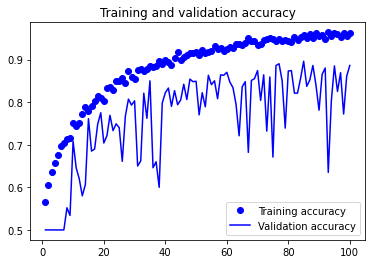

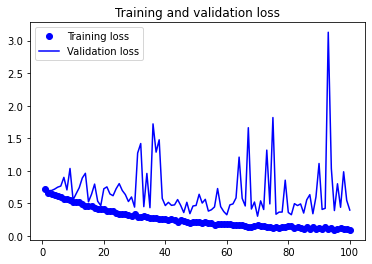

In [ ]:
import matplotlib.pyplot as plt

accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]

epochs = range(1, len(accuracy) + 1)

# 정확도 그래프
plt.plot(epochs, accuracy, "bo", label="Training accuracy")
plt.plot(epochs, val_accuracy, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()

# 손실 그래프
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

* 훈련 성능 평가

직접 구현한 모델이지만 테스트셋에 대한 정확도가 90% 정도 나온다. 
8장에서 직접 구현해서 훈련시켰을 때의 성능인 83% 정도보다 훨씬 높게 나온다.

In [ ]:
test_model = keras.models.load_model("mini_xception.keras")

test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

63/63 [==============================] - 2s 19ms/step - loss: 0.3141 - accuracy: 0.8785
Test accuracy: 0.878


**성능 높이기**

보다 성능을 높이려면 하이퍼파라미터 미세조정 및 앙상블 학습을 활용해야 한다(13장 참조).

- 하이퍼파라미터 미세조정: [케라스튜너(KerasTuner)](https://www.tensorflow.org/tutorials/keras/keras_tuner) 활용
- 앙상블 학습: [그레이디언트 부스팅(gradient boosting)](https://codingalzi.github.io/handson-ml2/notebooks/handson-ml2-07.html) 활용